<a href="https://colab.research.google.com/github/cedamusk/AI-N-ML/blob/main/Bayesian_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xarray as xr
from scipy.special import expit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [20]:
np.random.seed(42)

In [21]:
def generate_imbalanced_data(n_samples=1000):
  n_class_1=int(n_samples*0.7)
  n_class_2=n_samples-n_class_1

  X1=np.random.normal(loc=2, scale=1, size=(n_class_1, 2))
  y1=np.zeros(n_class_1)

  X2=np.random.normal(loc=4, scale=1.5, size=(n_class_2, 2))
  y2=np.ones(n_class_2)

  X=np.vstack((X1, X2))
  y=np.hstack((y1, y2))

  return X, y

In [22]:
X, y=generate_imbalanced_data(1000)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [24]:
with pm.Model() as model:
  weights=pm.Normal('weights', mu=0, sigma=2, shape=X_train_scaled.shape[1])
  bias=pm.Normal('bias', mu=0, sigma=2)

  linear_pred=pm.math.dot(X_train_scaled, weights)+ bias

  y_obs=pm.Bernoulli('y_obs', logit_p=linear_pred, observed=y_train)

  trace=pm.sample(2000, tune=1000, return_inferencedata=True)



Output()

Output()

In [25]:
def predict_proba_distribution(X_new, trace):
  w_samples=trace.posterior['weights'].values
  b_samples=trace.posterior['bias'].values

  w_samples=w_samples.reshape(-1, X_new.shape[1])
  b_samples=b_samples.flatten()

  linear_pred=np.dot(X_new, w_samples.T)+b_samples
  probs=expit(linear_pred)

  return probs

In [26]:
pred_probs=predict_proba_distribution(X_test_scaled, trace)
mean_probs=pred_probs.mean(axis=1)
std_probs=pred_probs.std(axis=1)

In [27]:
y_pred=(mean_probs > 0.5).astype(int)

In [28]:
print("\nBayesian Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")


Bayesian Logistic Regression Metrics:
Accuracy: 0.920
Precision: 0.918
Recall: 0.789
F1 Score: 0.849


In [29]:
fpr, tpr, _=roc_curve(y_test, mean_probs)
roc_auc=auc(fpr, tpr)
print(f"AUC-ROC:{roc_auc:.3f}")

AUC-ROC:0.951


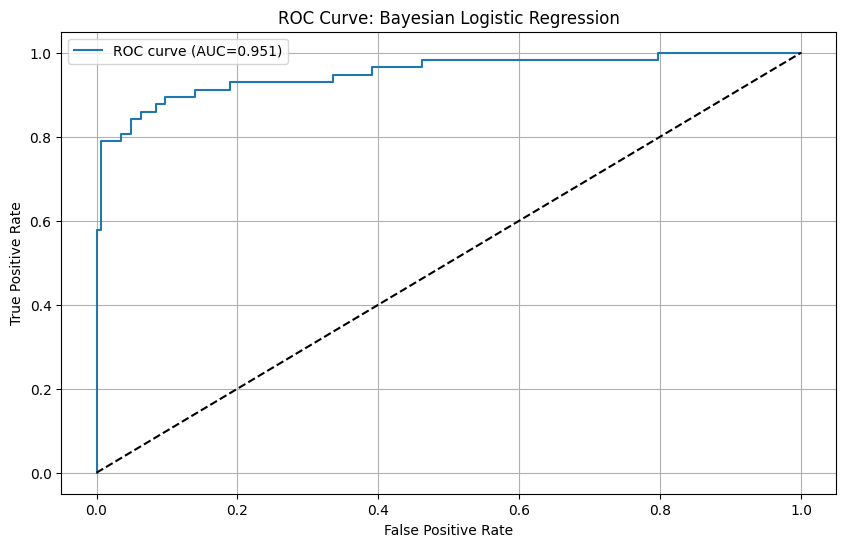

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Bayesian Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

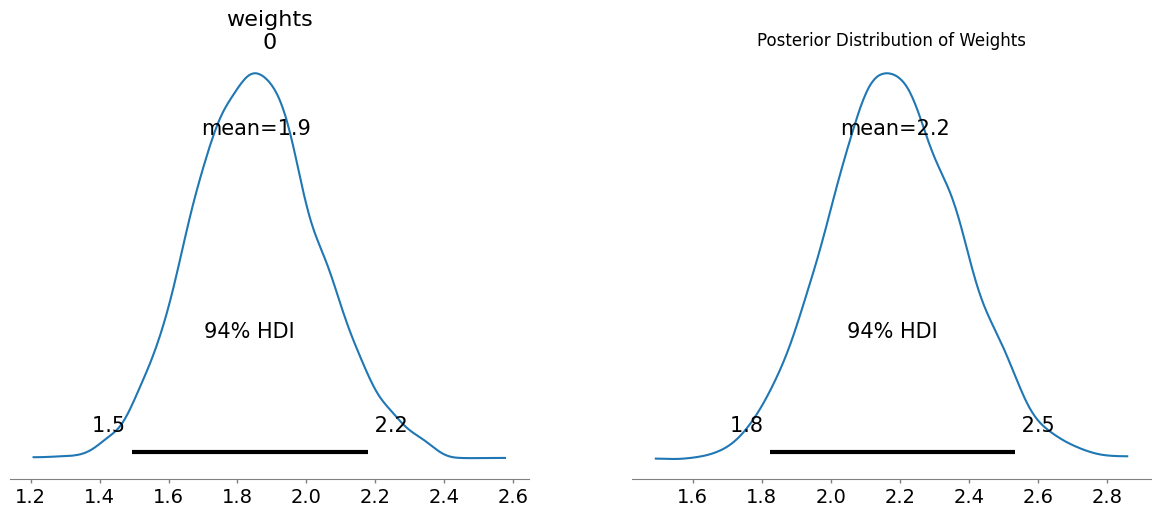

In [31]:
az.plot_posterior(trace, var_names=['weights'])
plt.title('Posterior Distribution of Weights')
plt.show()

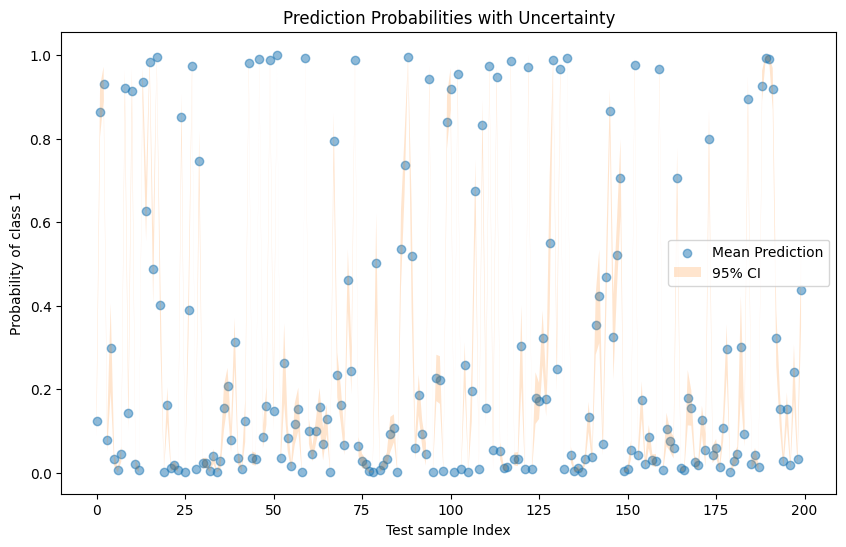

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mean_probs)), mean_probs, alpha=0.5, label='Mean Prediction')
plt.fill_between(range(len(mean_probs)),
                 mean_probs-2*std_probs,
                 mean_probs+2*std_probs,
                 alpha=0.2, label='95% CI')
plt.xlabel('Test sample Index')
plt.ylabel('Probability of class 1')
plt.title('Prediction Probabilities with Uncertainty')
plt.legend()
plt.show()

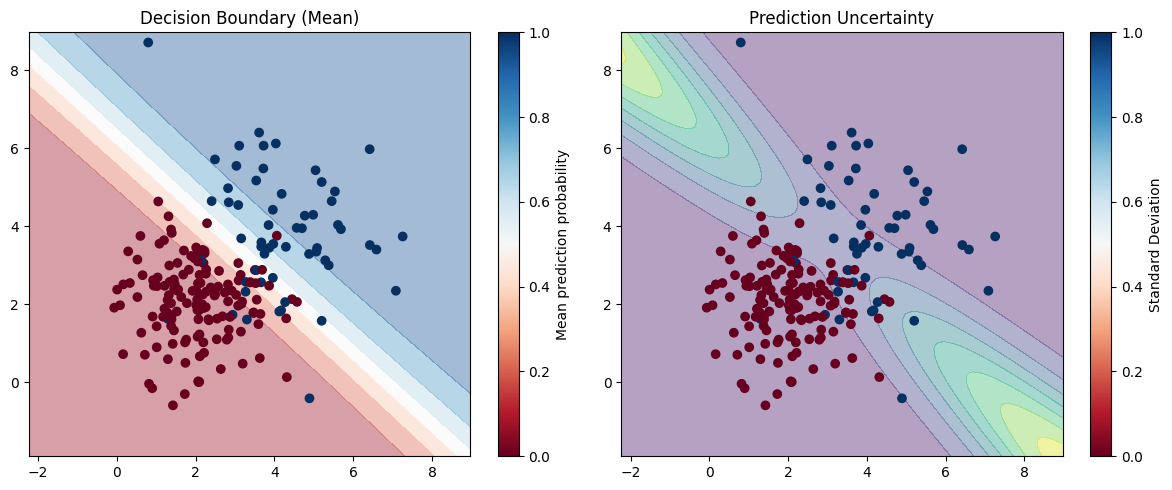

In [33]:
def plot_decision_boundary_with_uncertainty():
  x_min, x_max=X[:, 0].min()-1, X[:, 0].max()+1
  y_min, y_max=X[:, 1].min()-1, X[:, 0].max()+1
  xx, yy=np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

  grid_points=np.c_[xx.ravel(), yy.ravel()]
  scaled_grid=scaler.transform(grid_points)

  grid_probs=predict_proba_distribution(scaled_grid, trace)
  grid_mean=grid_probs.mean(axis=1).reshape(xx.shape)
  grid_std=grid_probs.std(axis=1).reshape(xx.shape)

  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.contourf(xx, yy, grid_mean, alpha=0.4, cmap='RdBu')
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdBu')
  plt.colorbar(label='Mean prediction probability')
  plt.title('Decision Boundary (Mean)')

  plt.subplot(122)
  plt.contourf(xx, yy, grid_std, alpha=0.4, cmap='viridis')
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdBu')
  plt.colorbar(label='Standard Deviation')
  plt.title('Prediction Uncertainty')

  plt.tight_layout()
  plt.show()

plot_decision_boundary_with_uncertainty()
